# Imports

In [578]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

# Load Brent Crude Oil Future Contracts Historical Data

In [579]:
# Load all sheets into a dictionary of DataFrames
file_path = "Crude Oil Brent Raw Data.xlsx"
sheets_dict = pd.read_excel(file_path, sheet_name=None)

In [580]:
def clean_single_contract(df):
    df = df.iloc[0:65, 1:10]  # B2:J66
    df = df.rename(columns=df.iloc[0])
    df = df.drop(0)
    df['Date'] = pd.to_datetime(df['Time'], errors='coerce')
    df = df.drop('Time', axis=1) 
    df = df[['Date'] + df.columns.tolist()[:-1]]
    df = df.dropna(subset=['Date'])
    return df

In [581]:
cleaned_months = {}

for name, raw_df in sheets_dict.items():
    try:
        cleaned = clean_single_contract(raw_df)
        cleaned['Contract'] = name
        cleaned_months[name] = cleaned
    except Exception as e:
        print(f"Error processing {name}: {e}")

In [582]:
# 1) Sort each DataFrame by Date descending and reset its index to 0…64
for name, df in cleaned_months.items():
    df.sort_values("Date", ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)

In [583]:
# Drop 1999 data for now
try:
    del cleaned_months['Dec 99 (CBZ99)']
except KeyError:
    pass

# Factor 1: Calendar Spreads

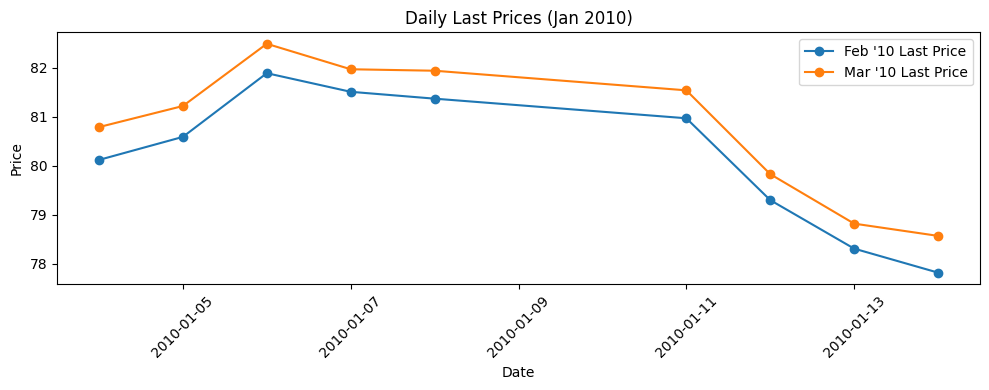

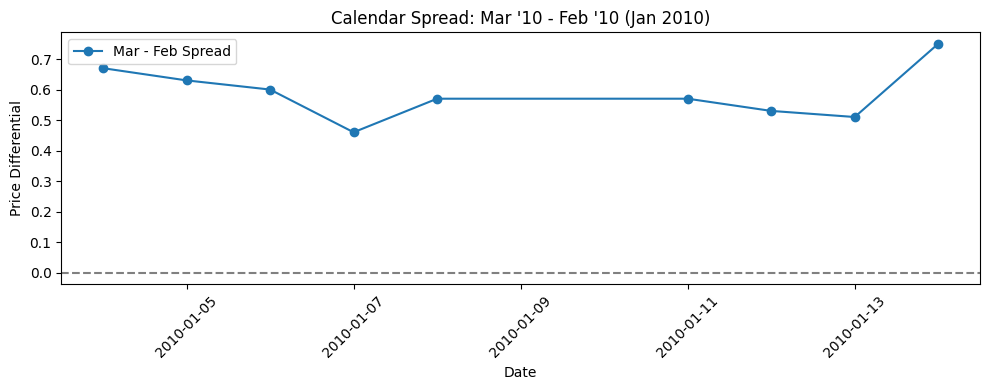

In [584]:
# 1. Get cleaned data for Feb '10 and Mar '10
df_feb = cleaned_months["Feb 10 (CBG10)"]
df_mar = cleaned_months["Mar 10 (CBH10)"]

# 2. Filter to January 2010
df_feb_jan = df_feb[df_feb["Date"].dt.month == 1]
df_mar_jan = df_mar[df_mar["Date"].dt.month == 1]

# 3. Merge on Date (inner join to align dates)
merged = pd.merge(
    df_feb_jan[["Date", "Last"]],
    df_mar_jan[["Date", "Last"]],
    on="Date",
    how="inner",
    suffixes=("_Feb", "_Mar")
)

# 4. Compute Spread: March – February (we're long March, short Feb)
merged["Spread"] = merged["Last_Mar"] - merged["Last_Feb"]

# 5. Plot prices
plt.figure(figsize=(10,4))
plt.plot(merged["Date"], merged["Last_Feb"], marker='o', label="Feb '10 Last Price")
plt.plot(merged["Date"], merged["Last_Mar"], marker='o', label="Mar '10 Last Price")
plt.title("Daily Last Prices (Jan 2010)")
plt.ylabel("Price")
plt.xlabel("Date")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Plot spread
plt.figure(figsize=(10,4))
plt.plot(merged["Date"], merged["Spread"], marker='o', label="Mar - Feb Spread")
plt.title("Calendar Spread: Mar '10 - Feb '10 (Jan 2010)")
plt.ylabel("Price Differential")
plt.xlabel("Date")
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [585]:
12 % 12 + 1

1

In [586]:
# Step 1: Get contract names
contract_names = list(cleaned_months.keys())[1:]

# Step 2: Initialize empty list to hold all spreads
spread_points = []

# Step 2: Iterate through each month-pair (March–April, April–May, etc.)
for i in range(len(contract_names) - 2):
    t1 = contract_names[i + 1]  # t+1
    t2 = contract_names[i + 2]  # t+2

    df1 = cleaned_months[t1]
    df2 = cleaned_months[t2]

    # Get month t
    target_month = i % 12 + 1

    # Filter to the target month (e.g., February)
    df1_month = df1[df1["Date"].dt.month == target_month]
    df2_month = df2[df2["Date"].dt.month == target_month]

    # Inner-join on actual dates
    merged = pd.merge(
        df1_month[["Date", "Last"]],
        df2_month[["Date", "Last"]],
        on="Date",
        how="inner",
        suffixes=("_T1", "_T2")
    )

    if merged.empty:
        continue

    # Compute spread: T+2 - T+1
    merged["Spread"] = merged["Last_T1"] - merged["Last_T2"]
    spread_points.append(merged[["Date", "Spread"]])

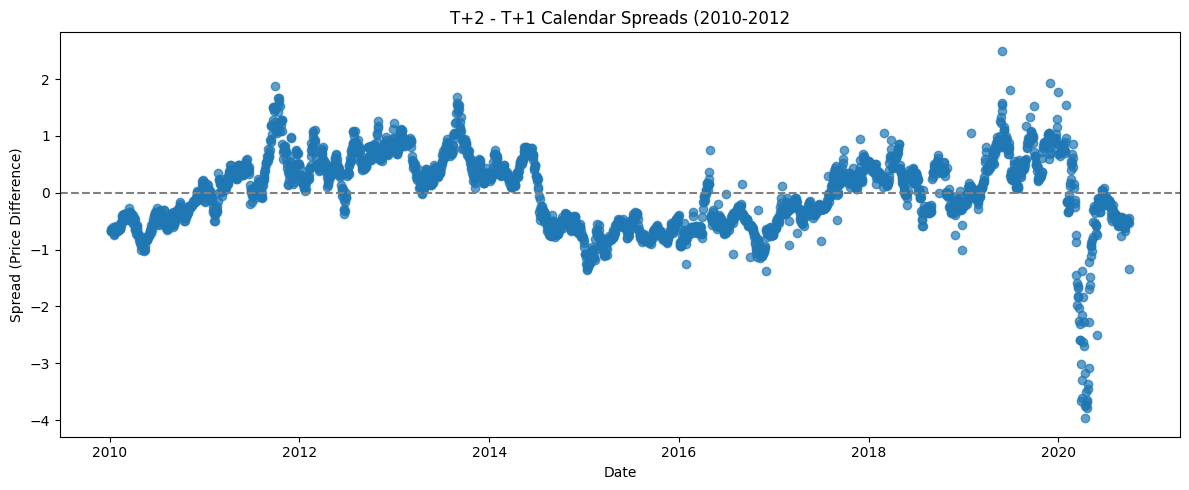

In [587]:
# Step 4: Combine all spread points into one DataFrame
all_spreads = pd.concat(spread_points, ignore_index=True)

# Step 5: Plot
plt.figure(figsize=(12, 5))
plt.scatter(all_spreads["Date"], all_spreads["Spread"], alpha=0.7)
plt.title("T+2 - T+1 Calendar Spreads (2010-2012")
plt.xlabel("Date")
plt.ylabel("Spread (Price Difference)")
plt.axhline(0, color="gray", linestyle="--")
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

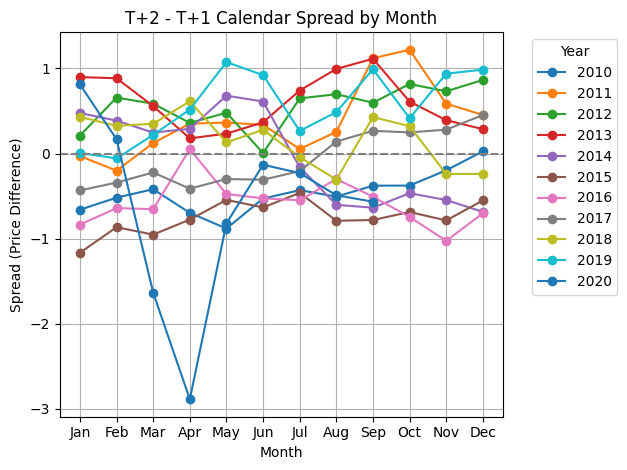

In [588]:
# Extract year and month
all_spreads["Year"] = all_spreads["Date"].dt.year
all_spreads["Month"] = all_spreads["Date"].dt.month

# Group by Year and Month, compute average spread in each month
monthly_avg = all_spreads.groupby(["Year", "Month"])["Spread"].mean().unstack(level=0)

# Plot
plt.figure(figsize=(12, 6))
monthly_avg.plot(marker='o')
plt.title("T+2 - T+1 Calendar Spread by Month")
plt.xlabel("Month")
plt.ylabel("Spread (Price Difference)")
plt.xticks(ticks=range(1,13), labels=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
])
plt.axhline(0, color="gray", linestyle="--")
plt.grid(True)
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Run CAPM on Price Differences

### Import Brent Crude Oil Futures Market Price

In [589]:
# Step 1: Load the CSV
market_df = pd.read_csv("EIA Europe Brent Spot Price.csv")

# Step 2: Rename columns to something simple
market_df.columns = ["Date", "BrentSpot"]

# Step 3: Convert Date to datetime format
market_df["Date"] = pd.to_datetime(market_df["Date"], format="%b %d, %Y")

# Step 4: Sort and filter relevant date range (matching your spread data)
market_df = market_df.sort_values("Date")

# Step 5: Compute daily returns
market_df["MarketReturn"] = market_df["BrentSpot"].pct_change(fill_method=None)
market_df = market_df.dropna()
market_df

,Date,BrentSpot,MarketReturn
1,1987-05-21,18.45,-0.009662
2,1987-05-22,18.55,0.005420
3,1987-05-25,18.60,0.002695
4,1987-05-26,18.63,0.001613
5,1987-05-27,18.60,-0.001610
...,...,...,...
9641,2025-05-20,66.93,0.010264
9642,2025-05-21,65.86,-0.015987
9643,2025-05-22,64.87,-0.015032
9644,2025-05-23,65.41,0.008324


### Merge With Spread Returns

In [590]:
# Step 6: Compute daily spread returns
all_spreads["SpreadReturn"] = all_spreads["Spread"].diff()

# Step 7: Merge on Date
df_merged = pd.merge(
    all_spreads[["Date", "SpreadReturn"]],
    market_df[["Date", "MarketReturn"]],
    on="Date",
    how="inner"
).dropna()

df_merged["SpreadReturn"] = pd.to_numeric(df_merged["SpreadReturn"], errors="coerce")
df_merged["MarketReturn"] = pd.to_numeric(df_merged["MarketReturn"], errors="coerce")

In [591]:
import pandas as pd
import statsmodels.api as sm

# assume `all_spreads` has columns ["Date","Spread"]
df = all_spreads.copy()
df = df.set_index("Date").sort_index()

# create a one-week lag
df["Spread_lag1"] = df["Spread"].shift(1)

# 2) Strip out any non-numeric characters (e.g. commas or “%”)
#    — only do the percent‐strip if your SpreadReturn actually has “%” at the end
if df["SpreadReturn"].dtype == object:
    df["SpreadReturn"] = (
        df["SpreadReturn"]
          .astype(str)
          .str.rstrip("%")      # remove trailing %
          .str.replace(",", "") # remove commas
    )

# 3) Convert to numeric, coercing any bad parses into NaN
for col in ["Spread","SpreadReturn","Spread_lag1"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    
df = df.dropna()

print(print(df.dtypes))

# fit AR(1)
X = sm.add_constant(df["Spread_lag1"])
y = df["Spread"]
ar1 = sm.OLS(y, X).fit()
print(ar1.summary())

# make in-sample predictions
df["Spread_pred_ar1"] = ar1.predict(X)


Spread          float64
Year              int32
Month             int32
SpreadReturn    float64
Spread_lag1     float64
dtype: object
None
                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                 4.744e+04
Date:                Fri, 30 May 2025   Prob (F-statistic):               0.00
Time:                        14:27:49   Log-Likelihood:                 1182.9
No. Observations:                2767   AIC:                            -2362.
Df Residuals:                    2765   BIC:                            -2350.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025    

In [592]:
df_merged

,Date,SpreadReturn,MarketReturn
1,2010-01-28,-0.03,-0.028866
2,2010-01-27,0.03,0.001652
3,2010-01-26,0.03,0.006234
4,2010-01-25,-0.04,-0.007562
5,2010-01-22,-0.05,-0.018886
...,...,...,...
2712,2020-09-07,0.05,-0.010462
2713,2020-09-04,0.01,-0.037921
2714,2020-09-03,0.00,0.000468
2715,2020-09-02,0.08,-0.066054


### Run Simple Linear Regression

In [593]:
# 1) Merge spreads with spot returns
merged = (
    df.merge(
        market_df[["Date","MarketReturn"]],
        on="Date", how="inner"
    )
    .sort_values("Date")
)

# 2) Create the target: one-week-ahead spread
merged["Spread_next"] = merged["Spread"].shift(-1)
data = merged.dropna(subset=["Spread_next","MarketReturn"])

# 3) Fit a two-variable linear model
X = sm.add_constant(data[["Spread","MarketReturn"]])
y = data["Spread_next"]
linreg = sm.OLS(y, X).fit()
print(linreg.summary())

# 4) Attach predictions
data["Spread_pred_lin"] = linreg.predict(X)

                            OLS Regression Results                            
Dep. Variable:            Spread_next   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                 2.250e+04
Date:                Fri, 30 May 2025   Prob (F-statistic):               0.00
Time:                        14:27:49   Log-Likelihood:                 1124.3
No. Observations:                2714   AIC:                            -2243.
Df Residuals:                    2711   BIC:                            -2225.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0005      0.003     -0.169   

/var/folders/vs/b51fgl4x6bsbtncxc8sg87c40000gn/T/ipykernel_6407/3109232779.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Spread_pred_lin"] = linreg.predict(X)


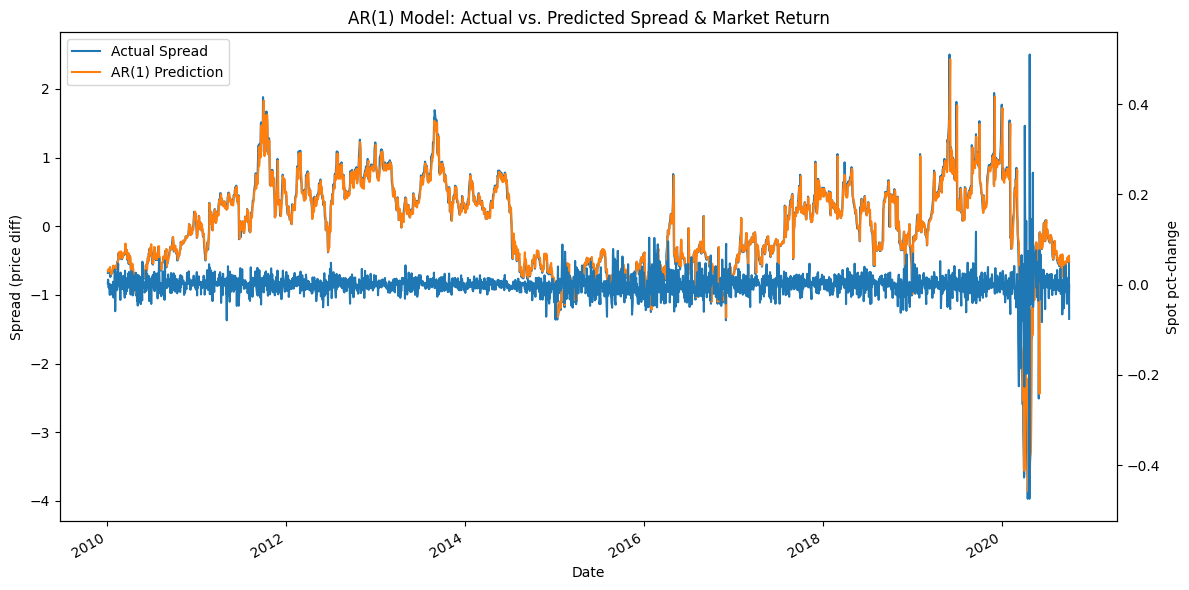

NameError: name 'co' is not defined

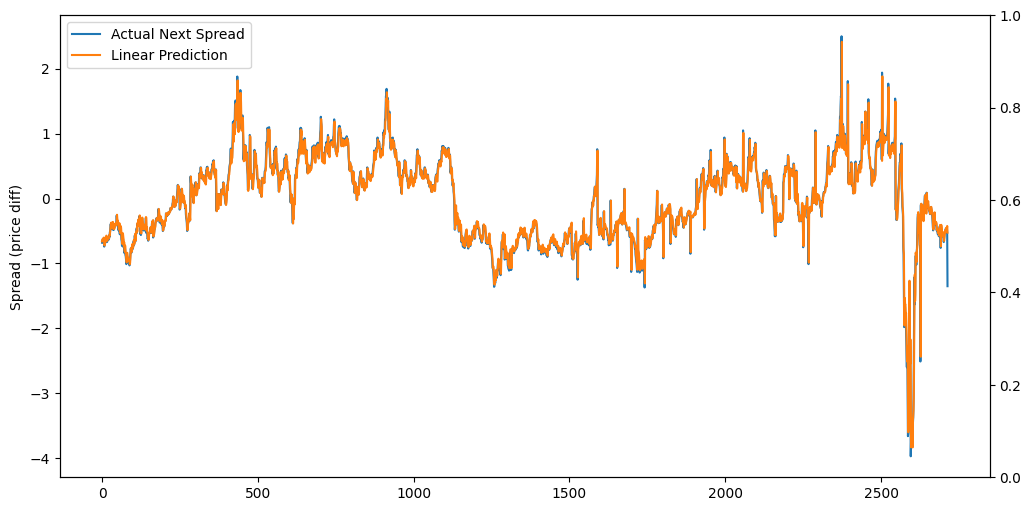

In [608]:
import matplotlib.pyplot as plt

# --- 1) AR(1) vs. Market Return ---
# df_ar: DateTimeIndex, columns ['Spread','Spread_pred_ar1']
# market_df: DateTimeIndex, column 'MarketReturn'

# align
combined_ar = (
    pd.DataFrame({
        "Actual Spread":       df_ar["Spread"],
        "AR(1) Prediction":    df_ar["Spread_pred_ar1"],
        "Market Return":       market_df["MarketReturn"]
    })
    .dropna()
)

fig, ax1 = plt.subplots(figsize=(12,6))
combined_ar[["Actual Spread","AR(1) Prediction"]].plot(ax=ax1)
ax1.set_ylabel("Spread (price diff)")
ax2 = ax1.twinx()
combined_ar["Market Return"].plot(ax=ax2)
ax2.set_ylabel("Spot pct‐change")
ax1.set_title("AR(1) Model: Actual vs. Predicted Spread & Market Return")
fig.tight_layout()
plt.show()


# --- 2) Linear Model vs. Market Return ---
# data: DateTimeIndex, columns ['Spread_next','Spread_pred_lin','MarketReturn']

combined_lin = (
    pd.DataFrame({
        "Actual Next Spread":     data["Spread_next"],
        "Linear Prediction":      data["Spread_pred_lin"],
        "Market Return":          data["MarketReturn"]
    })
    .dropna()
)

fig, ax1 = plt.subplots(figsize=(12,6))
combined_lin[["Actual Next Spread","Linear Prediction"]].plot(ax=ax1)
ax1.set_ylabel("Spread (price diff)")
ax2 = ax1.twinx()
co


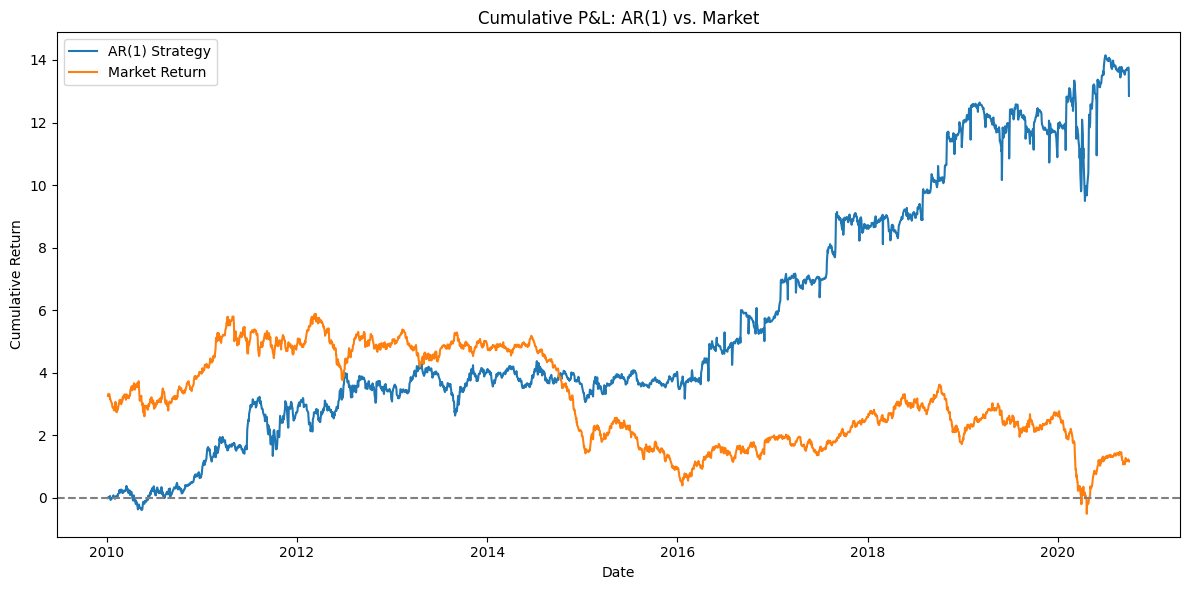

In [594]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Prepare your AR(1) P&L (you’ve already done this)
# df_ar must have a DateTimeIndex and cumret_ar1
# e.g.:
df_ar = df_ar.reset_index().set_index("Date").sort_index()

# 2) Prepare the market cumulative return
# market_df has columns ["Date","MarketReturn"] where MarketReturn is pct change
mkt = market_df[["Date","MarketReturn"]].dropna().copy()
mkt["Date"] = pd.to_datetime(mkt["Date"])
mkt = mkt.set_index("Date").sort_index()

# compute cum‐return: (1+r1)*(1+r2)*... −1
mkt["cumret_mkt"] = (1 + mkt["MarketReturn"]).cumprod() - 1

# 3) Align the two series on the same dates
combined = pd.DataFrame({
    "AR1": df_ar["cumret_ar1"],
    "Market": mkt["cumret_mkt"]
}).dropna()   # inner‐join on index

# 4) Plot
plt.figure(figsize=(12,6))
plt.plot(combined.index, combined["AR1"],    label="AR(1) Strategy")
plt.plot(combined.index, combined["Market"], label="Market Return")
plt.axhline(0, linestyle="--", color="gray")
plt.title("Cumulative P&L: AR(1) vs. Market")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.tight_layout()
plt.show()


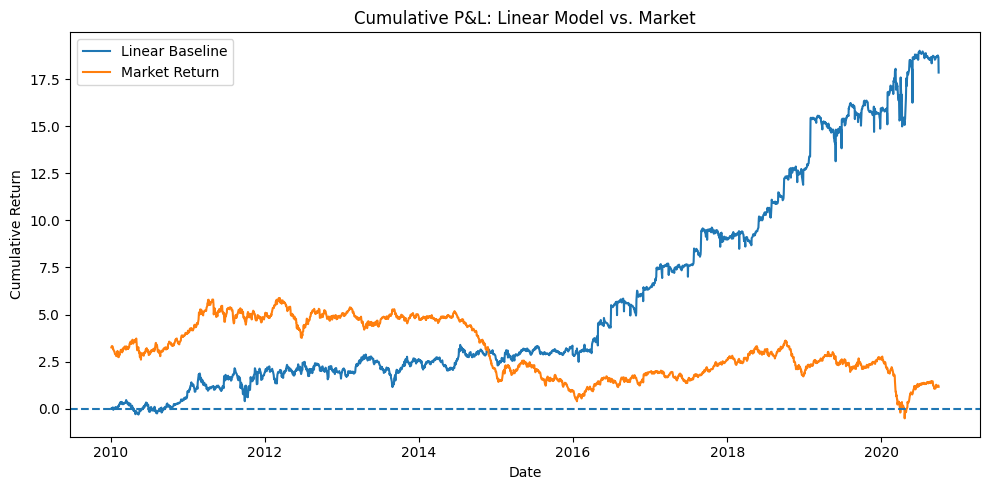

In [595]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Load & prepare market returns (if not already in memory) ---
market_df = pd.read_csv("EIA Europe Brent Spot Price.csv")
market_df.columns = ["Date", "BrentSpot"]
market_df["Date"] = pd.to_datetime(market_df["Date"], format="%b %d, %Y")
market_df = market_df.sort_values("Date").dropna(subset=["BrentSpot"])
market_df["MarketReturn"] = market_df["BrentSpot"].pct_change()
market_df = market_df.dropna()
market_df = market_df.set_index("Date")

# compute cumulative buy‐and‐hold return
market_df["cumret_mkt"] = (1 + market_df["MarketReturn"]).cumprod() - 1

# --- 2) Prepare your linear‐model P&L (df_lin) ---
# Ensure df_lin has a DateTime index and cumret_lin column
df_lin = df_lin.copy()
if "Date" in df_lin.columns:
    df_lin["Date"] = pd.to_datetime(df_lin["Date"])
    df_lin = df_lin.set_index("Date")
df_lin = df_lin.sort_index()

# --- 3) Align and plot ---
combined = pd.DataFrame({
    "Linear Baseline": df_lin["cumret_lin"],
    "Buy & Hold Market": market_df["cumret_mkt"]
}).dropna()

plt.figure(figsize=(10, 5))
plt.plot(combined.index, combined["Linear Baseline"], label="Linear Baseline")
plt.plot(combined.index, combined["Buy & Hold Market"], label="Market Return")
plt.axhline(0, linestyle="--")
plt.title("Cumulative P&L: Linear Model vs. Market")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.tight_layout()
plt.show()


Text(0, 0.5, 'Predicted Spreadₜ₊₁')

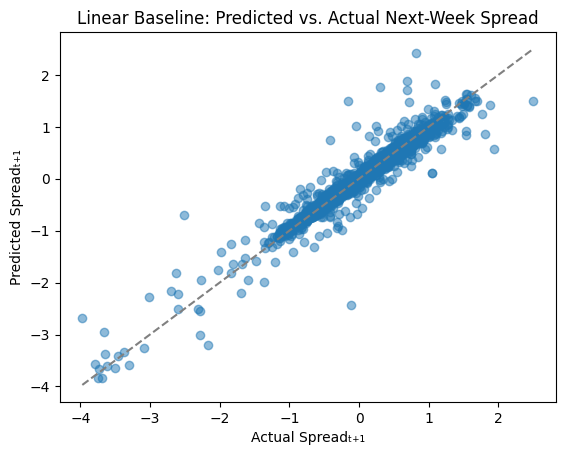

In [596]:
plt.scatter(data["Spread_next"], data["Spread_pred_lin"], alpha=0.5)
plt.plot([data.Spread_next.min(), data.Spread_next.max()],
         [data.Spread_next.min(), data.Spread_next.max()], 
         "--", color="gray")
plt.title("Linear Baseline: Predicted vs. Actual Next-Week Spread")
plt.xlabel("Actual Spreadₜ₊₁")
plt.ylabel("Predicted Spreadₜ₊₁")

Text(0, 0.5, 'Residual (Actual – Predicted)')

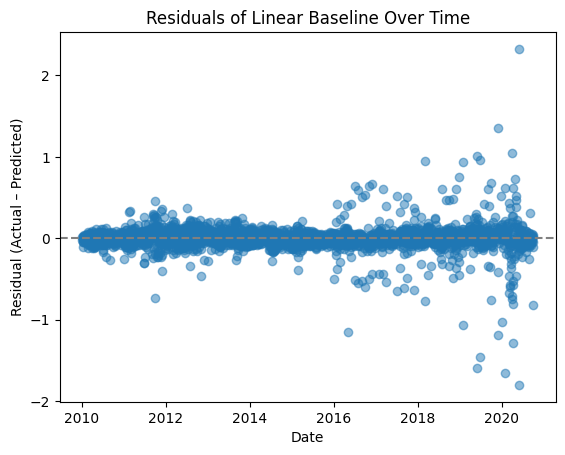

In [597]:
resids = data["Spread_next"] - data["Spread_pred_lin"]
plt.scatter(data["Date"], resids, alpha=0.5)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Residuals of Linear Baseline Over Time")
plt.xlabel("Date")
plt.ylabel("Residual (Actual – Predicted)")

Text(0, 0.5, 'Density')

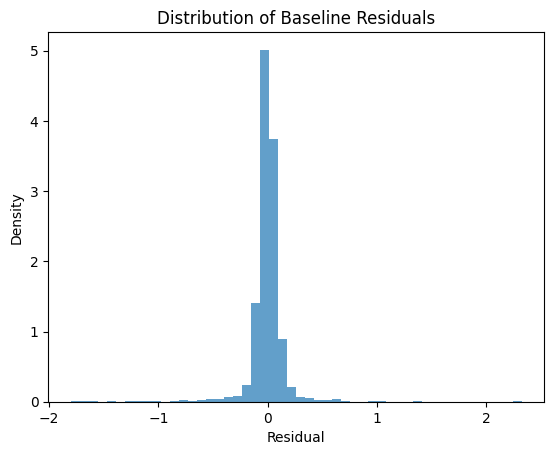

In [598]:
plt.hist(resids, bins=50, density=True, alpha=0.7)
plt.title("Distribution of Baseline Residuals")
plt.xlabel("Residual")
plt.ylabel("Density")

In [599]:
X = sm.add_constant(df_merged["MarketReturn"])  # Adds intercept
y = df_merged["SpreadReturn"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           SpreadReturn   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.497
Date:                Fri, 30 May 2025   Prob (F-statistic):              0.221
Time:                        14:27:50   Log-Likelihood:                 656.45
No. Observations:                2716   AIC:                            -1309.
Df Residuals:                    2714   BIC:                            -1297.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4.161e-05      0.004      0.011   

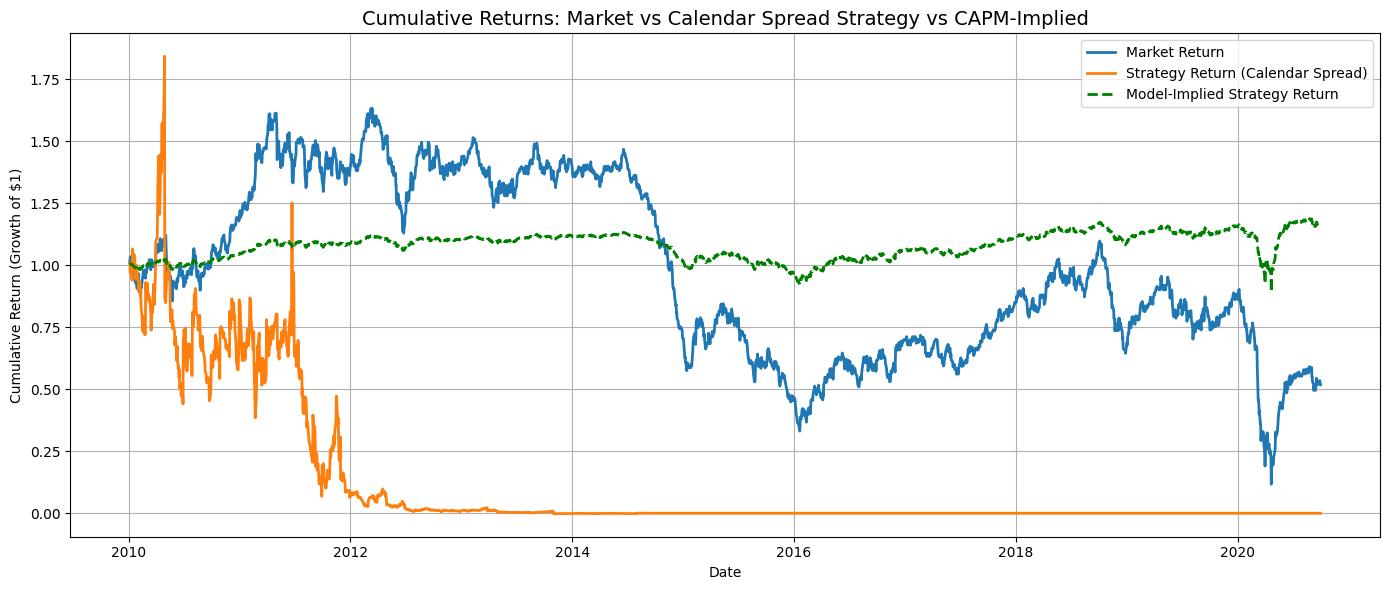

In [600]:
alpha = model.params["const"]
beta = model.params["MarketReturn"]

# Step 2: Compute CAPM-implied strategy return each day
df_merged["CAPM_Return"] = alpha + beta * df_merged["MarketReturn"]

# Step 3: Compute cumulative returns (growth of $1)
df_merged = df_merged.sort_values("Date")
df_merged["Cum_Market"] = (1 + df_merged["MarketReturn"]).cumprod()
df_merged["Cum_Strategy"] = (1 + df_merged["SpreadReturn"]).cumprod()
df_merged["Cum_CAPM"] = (1 + df_merged["CAPM_Return"]).cumprod()

# Step 4: Plot
plt.figure(figsize=(14, 6))
plt.plot(df_merged["Date"], df_merged["Cum_Market"], label="Market Return", linewidth=2)
plt.plot(df_merged["Date"], df_merged["Cum_Strategy"], label="Strategy Return (Calendar Spread)", linewidth=2)
plt.plot(df_merged["Date"], df_merged["Cum_CAPM"], label="Model-Implied Strategy Return", linestyle="--", linewidth=2, color='green')

plt.title("Cumulative Returns: Market vs Calendar Spread Strategy vs CAPM-Implied", fontsize=14)
plt.ylabel("Cumulative Return (Growth of $1)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Factor 2: Gasoline Prices/Futures and S&P

## Load in Gasoline Prices

In [601]:
# Path to your CSV files
data_path = "oil_companies_data"

# List of tickers
oil_companies_tickers = [
    'XOM', 'CVX', 'BP', 'COP', 'EOG', 'OXY', 'SLB', 'HAL', 'VLO', 'PBR', 
    'GSPC', 'gas_futures'
]

# Container for all data
price_data = {}

# Loop through each file and load
for ticker in oil_companies_tickers:
    # Adjust filename to match your convention
    filepath = os.path.join(data_path, f"{ticker}_data.csv")

    try:
        df = pd.read_csv(filepath)
        if ticker != 'gas_futures':
            df = df.drop([0, 1])
            df = df.rename(columns={'Price': 'Date'})
        
        # Normalize column names
        df.columns = [col.strip() for col in df.columns]
        
        # Parse date
        df['Date'] = pd.to_datetime(df['Date'])
        
        if ticker != 'gas_futures':
            df = df[['Date', 'Close']].rename(columns={'Close': ticker})
        else:
            df = df[['Date', 'Price']].rename(columns={'Price': ticker})
        df.set_index('Date', inplace=True)
        price_data[ticker] = df

    except Exception as e:
        print(f"Failed to load {ticker}: {e}")

# Combine all tickers by date
combined_prices = pd.concat(price_data.values(), axis=1, join='inner').sort_index()
combined_prices

,XOM,CVX,BP,COP,EOG,OXY,SLB,HAL,VLO,PBR,GSPC,gas_futures
Date,,,,,,,,,,,,
2005-10-04,31.07428550720215,29.5751953125,24.804637908935547,26.250892639160156,26.521289825439453,23.41230010986328,27.034879684448242,24.621795654296875,29.270416259765625,4.151123046875,1214.469970703125,1.8453
2005-10-05,30.253162384033203,29.198692321777344,23.97540855407715,25.005558013916016,25.262081146240234,22.79693603515625,26.219697952270508,23.243751525878906,27.514503479003906,3.9237561225891113,1196.3900146484375,1.7650
2005-10-06,30.058143615722656,28.238571166992188,23.65093231201172,24.5192813873291,23.840160369873047,22.03492546081543,26.243074417114258,22.694780349731445,26.8043270111084,3.740278482437134,1191.489990234375,1.7200
2005-10-07,30.586734771728516,28.70920753479004,23.748275756835938,25.143930435180664,24.43085289001465,22.31098747253418,26.684091567993164,23.419279098510742,28.01656150817871,3.893887758255005,1195.9000244140625,1.7400
2005-10-10,30.02222442626953,28.393875122070312,23.93936538696289,24.997665405273438,23.974567413330078,22.132707595825195,26.727519989013672,22.754526138305664,27.324613571166992,3.847561836242676,1187.3299560546875,1.7300
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-11,107.43465423583984,151.8142547607422,35.045013427734375,114.08428955078125,122.1171875,62.304290771484375,58.58402633666992,40.001121520996094,136.2747802734375,11.923880577087402,4487.4599609375,2.6365
2023-09-12,110.56846618652344,154.6417694091797,34.58210372924805,116.58499145507812,125.79467010498047,64.83199310302734,59.86618423461914,41.0079345703125,138.66387939453125,11.988595962524414,4461.89990234375,2.6552
2023-09-13,109.580322265625,154.07626342773438,34.72732925415039,115.85562133789062,124.68766784667969,64.7246322631836,58.439422607421875,40.56261444091797,137.92442321777344,11.980506896972656,4467.43994140625,2.6630


## Run CAPM

In [602]:
# Compute returns
combined_prices = combined_prices.apply(pd.to_numeric, errors='coerce')
returns = combined_prices.pct_change().dropna()

# 1. Merge all ticker returns into df_merged
returns_reset = returns.reset_index()

# Add each ticker to df_merged
tickers = [t for t in returns.columns]
for ticker in tickers:
    df_merged = pd.merge(
        df_merged,
        returns_reset[["Date", ticker]],
        on="Date",
        how="inner"
    )

                            OLS Regression Results                            
Dep. Variable:           SpreadReturn   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     4.036
Date:                Fri, 30 May 2025   Prob (F-statistic):           1.31e-06
Time:                        14:27:51   Log-Likelihood:                 683.34
No. Observations:                2683   AIC:                            -1339.
Df Residuals:                    2669   BIC:                            -1256.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0009      0.004     -0.238   

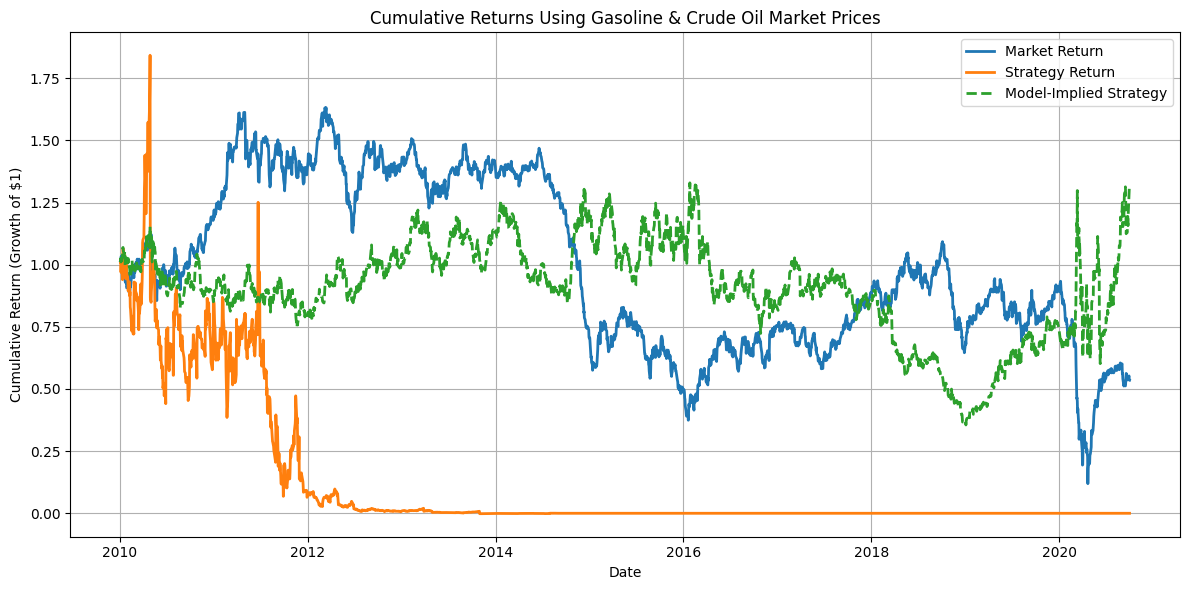

In [603]:
# --- Step 1: Define predictors and target ---
# Choose extra explanatory factors
extra_factors = ["MarketReturn"] + oil_companies_tickers
X = df_merged[extra_factors]
X = sm.add_constant(X)
y = df_merged["SpreadReturn"]

# --- Step 2: Fit model ---
capm_model = sm.OLS(y, X).fit()
print(capm_model.summary())

# --- Step 3: Compute model-implied returns ---
df_merged["CAPM_Predicted"] = capm_model.predict(X)

# --- Step 4: Compute cumulative returns ---
df_merged["Cum_Strategy"] = (1 + df_merged["SpreadReturn"]).cumprod()
df_merged["Cum_CAPM"] = (1 + df_merged["CAPM_Predicted"]).cumprod()
df_merged["Cum_Market"] = (1 + df_merged["MarketReturn"]).cumprod()

# --- Step 5: Plot cumulative returns ---
plt.figure(figsize=(12, 6))
plt.plot(df_merged["Date"], df_merged["Cum_Market"], label="Market Return", linewidth=2)
plt.plot(df_merged["Date"], df_merged["Cum_Strategy"], label="Strategy Return", linewidth=2)
plt.plot(df_merged["Date"], df_merged["Cum_CAPM"], label="Model-Implied Strategy", linestyle='--', linewidth=2)

plt.title("Cumulative Returns Using Gasoline & Crude Oil Market Prices")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (Growth of $1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Factor 3: Treasury Rates

In [604]:
# Load real long-term rates
lt_rates = pd.read_csv("treasury_data/real-long-term-rates-2000-2023.csv")
lt_rates['Date'] = pd.to_datetime(lt_rates['Date'], format="%m/%d/%y")
lt_rates = lt_rates.rename(columns={'LT Real Average (10> Yrs)': 'LT_Rate'})
lt_rates.set_index('Date', inplace=True)

# Load and parse yield curve rates
yc_rates = pd.read_csv("treasury_data/yield-curve-rates-1990-2023.csv")
yc_rates['Date'] = pd.to_datetime(yc_rates['Date'], format="%m/%d/%y")

# Define mapping for rename
yc_rename = {
    '1 Mo': 'm1', '2 Mo': 'm2', '3 Mo': 'm3', '4 Mo': 'm4', '6 Mo': 'm6',
    '1 Yr': 'y1', '2 Yr': 'y2', '3 Yr': 'y3', '5 Yr': 'y5', '7 Yr': 'y7',
    '10 Yr': 'y10', '20 Yr': 'y20', '30 Yr': 'y30'
}

# Strip spaces and rename
yc_rates.rename(columns=yc_rename, inplace=True)
yc_rates.set_index('Date', inplace=True)

# Load and parse bill rates
bill_rates = pd.read_csv("treasury_data/bill-rates-2002-2023.csv")
bill_rates['Date'] = pd.to_datetime(bill_rates['Date'], format="%m/%d/%y")

# Define mapping
bill_rename = {
    '4 WEEKS BANK DISCOUNT': 'wbd4',
    '4 WEEKS COUPON EQUIVALENT': 'wce4',
    '8 WEEKS BANK DISCOUNT': 'wbd8',
    '8 WEEKS COUPON EQUIVALENT': 'wce8',
    '13 WEEKS BANK DISCOUNT': 'wbd13',
    '13 WEEKS COUPON EQUIVALENT': 'wce13',
    '17 WEEKS BANK DISCOUNT': 'wbd17',
    '17 WEEKS COUPON EQUIVALENT': 'wce17',
    '26 WEEKS BANK DISCOUNT': 'wbd26',
    '26 WEEKS COUPON EQUIVALENT': 'wce26',
    '52 WEEKS BANK DISCOUNT': 'wbd52',
    '52 WEEKS COUPON EQUIVALENT': 'wce52'
}

# Strip and rename
bill_rates.rename(columns=bill_rename, inplace=True)
bill_rates.set_index('Date', inplace=True)


In [605]:
# Reset index for merge
lt_rates_reset = lt_rates.reset_index()
yc_reset = yc_rates.reset_index()
bill_reset = bill_rates.reset_index()

# Merge into df_merged (assumes 'Date' already exists in df_merged)
df_merged = pd.merge(df_merged, yc_reset, on="Date", how="left")
df_merged = pd.merge(df_merged, bill_reset, on="Date", how="left")

# Merge each as needed (can use only a subset of columns if you want)
df_merged = pd.merge(df_merged, lt_rates_reset[["Date", "LT_Rate"]], on="Date", how="left")

In [606]:
df_merged["LT_Rate_Change"] = df_merged["LT_Rate"].diff()

In [607]:
# Define predictor columns and dropna
treasury_factors = ["LT_Rate_Change"]
model_data = df_merged[["SpreadReturn"] + treasury_factors + ['GSPC', 'OXY', 'COP', 'MarketReturn']].dropna()

X = sm.add_constant(model_data[treasury_factors + ['GSPC', 'OXY', 'COP', 'MarketReturn']])
y = model_data["SpreadReturn"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           SpreadReturn   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     8.973
Date:                Fri, 30 May 2025   Prob (F-statistic):           1.82e-08
Time:                        14:27:51   Log-Likelihood:                 652.70
No. Observations:                2644   AIC:                            -1293.
Df Residuals:                    2638   BIC:                            -1258.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0010      0.004     -0.